In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
activation functions and their derivatives
"""

def relu_k(x, k):
    return np.maximum(x**k, 0)

def d_relu_k(x, k):
    return k * x**(k-1) * (x > 0)

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return 1.0 * (x > 0)

def sin(x, k=None):
    return np.sin(x)

def cos(x, k=None):
    return np.cos(x)

def d_cos(x, k=None):
    return -np.sin(x)

In [3]:
"""
analytic solution: Equation (4)-(5) on page 3

u = <x, x'> / ||x|| ||x'||

k(u) = u k_0(u) + k_1(u)

k_0 = 1/pi (pi - arccos(u))
k_1 = 1/pi (u (pi - arccos(u)) + sqrt(1 - u^2))

assuming x == x'
"""

def kappa(u):
    pi = np.pi
    k_0 = (1/pi) * (pi - np.arccos(u))
    k_1 = (1/pi) * (u * (pi - np.arccos(u)) + np.sqrt(1 - u**2))
    return u * k_0 + k_1

def analytic_kernel_entry_2d(x, y, k=None,activation=None): # x, y vector
    # k is just for fuction call convenience
    # don't need norm_prod because x y are both unit vector, norm=1
    norm_prod = np.linalg.norm(x) * np.linalg.norm(y)
    # for 1d input on line, it's just x * y
    inner_prod = x.dot(y)
    # for numeircal stability: if not -1 < u < 1, arccos(u) is undefined
    if (inner_prod > 1.0):
        inner_prod = 1.0
    if (inner_prod < -1.0):
        inner_prod = -1.0
    u = inner_prod
    
    return kappa(u)

In [4]:
def numerical_kernel_entry(x, y, k=1, activation='relu_k'):
    """
    https://papers.nips.cc/paper/2019/file/c4ef9c39b300931b69a36fb3dbb8d60e-Paper.pdf
    equation (3) on page 3 and section 3.3 on page 7 
    
    x, y are vectors
    activation = ['relu_k', 'sin', 'cos']
    d_activation is the derivative of activation function
    
    k=1 means regular relu
    
    K(x, x') = <x, x'> E[sig'(<w, x>)sig'(<w, x'>)] + E[sig(<w, x>)sig(<w, x'>)]
    E {w ~ N(0, 1)}
    """
    num_samples = 1000
    
    # fix this - vectorize
    w1, w2 = np.random.normal(0.0, 1.0, size=[2, num_samples, 2])
    
    # w1: (num_samples, 2) x: (2,)
    # get dot products
    w1x = w1.dot(x) # (num_samples,)
    w1y = w1.dot(y) # (num_samples,)
    w2x = w2.dot(x)
    w2y = w2.dot(y)
    
    if activation == 'relu_k':
        activation_func = relu_k
        d_activation = d_relu_k
    elif activation == 'sin':
        activation_func = sin
        d_activation = cos
    elif activation == 'cos':
        activation_func = cos
        d_activation = d_cos        
    
    sigma_w1x = np.asarray(activation_func(w1x, k)) # (num_samples,)
    sigma_w1y = np.asarray(activation_func(w1y, k)) # (num_samples,)
    sigma_w2x = np.asarray(d_activation(w2x, k))
    sigma_w2y = np.asarray(d_activation(w2y, k))  

    # dot product does the summation in a vectorized way
    expection_1 = sigma_w1x.dot(sigma_w1y) / num_samples
    expection_2 = sigma_w2x.dot(sigma_w2y) / num_samples
    
    return 2 * (x.dot(y)) * expection_2 + 2 * expection_1

In [33]:
# execute
def calc_NTK_2d(kernel_entry_func, k=1, activation='relu_k'):
    num_inputs = 100
    pi = np.pi
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniform
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta)))

    # make kernel
    kernel = np.zeros((num_inputs, num_inputs))

    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = kernel_entry_func(x[:, i], x[:, j], k, activation)
    
    # sort eigenvalues in descending order
    global eigenvalues 
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1] 
    # plt.plot(sorted_eigenvalues)
    plt.loglog(sorted_eigenvalues[:-1])
    return eigenvalues

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


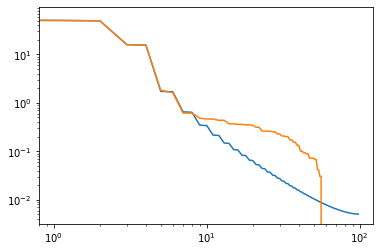

In [6]:
kernel_analytic = calc_NTK_2d(analytic_kernel_entry_2d)
kernel_numerical = calc_NTK_2d(numerical_kernel_entry, k=1)

In [7]:
# error
np.max((kernel_numerical - kernel_analytic), axis=1)

array([0.11882433, 0.1520835 , 0.18544356, 0.19391578, 0.16648728,
       0.21440587, 0.15316971, 0.20316297, 0.11211727, 0.1193895 ,
       0.11979961, 0.15004663, 0.15353646, 0.14212479, 0.11833868,
       0.12947669, 0.15252648, 0.15942284, 0.2158627 , 0.18289427,
       0.15044048, 0.12901919, 0.1054251 , 0.10703991, 0.14596382,
       0.15846261, 0.16624332, 0.1223707 , 0.15819978, 0.15110682,
       0.2371045 , 0.1043876 , 0.1431353 , 0.1660904 , 0.17868067,
       0.19896635, 0.17262331, 0.13738155, 0.15736671, 0.09933936,
       0.18712543, 0.11920143, 0.14030475, 0.17184763, 0.12494736,
       0.15353487, 0.16355415, 0.15825512, 0.1159095 , 0.18486706,
       0.15114307, 0.20239564, 0.11841447, 0.10870861, 0.10993116,
       0.1862584 , 0.13792611, 0.12246004, 0.25047625, 0.19623274,
       0.14181558, 0.25066396, 0.1741115 , 0.15142256, 0.23327749,
       0.21585881, 0.11371676, 0.21521272, 0.12661927, 0.1160383 ,
       0.25759464, 0.20435361, 0.12609291, 0.16879782, 0.18459

array([6.08592158e+01, 5.04558273e+01, 4.95050539e+01, 1.59087527e+01,
       1.56051463e+01, 1.72925020e+00, 1.69577519e+00, 6.53044462e-01,
       6.40382356e-01, 3.47069446e-01, 3.40345375e-01, 2.16711329e-01,
       2.12522093e-01, 1.48777671e-01, 1.45911013e-01, 1.08777994e-01,
       1.06690723e-01, 8.32011610e-02, 8.16125782e-02, 6.58407313e-02,
       6.45908423e-02, 5.35110423e-02, 5.25018530e-02, 4.44367717e-02,
       4.36048624e-02, 3.75635843e-02, 3.68660740e-02, 3.22327095e-02,
       3.16395565e-02, 2.80150770e-02, 2.75046036e-02, 2.46213700e-02,
       2.41775413e-02, 2.18506942e-02, 2.14613929e-02, 1.95599893e-02,
       1.92158903e-02, 1.76451258e-02, 1.73389353e-02, 1.60288405e-02,
       9.80926843e-16, 1.57547743e-02, 1.46528245e-02, 1.44062378e-02,
       1.34724048e-02, 1.32495257e-02, 1.24528878e-02, 1.22506247e-02,
       1.15670021e-02, 1.13827971e-02, 1.07930721e-02, 1.06247941e-02,
       1.01136991e-02, 9.95955798e-03, 9.51478783e-03, 9.37327223e-03,
      

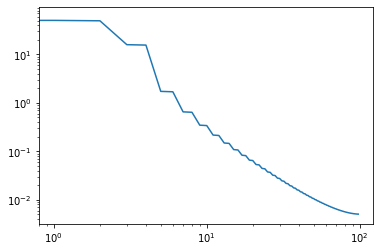

In [34]:
calc_NTK_2d(analytic_kernel_entry_2d)

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([ 6.08814105e+01+0.j        ,  5.04172551e+01+0.j        ,
        4.95638512e+01+0.j        ,  1.59203063e+01+0.j        ,
        1.55709918e+01+0.j        ,  1.76049245e+00+0.j        ,
        1.66571800e+00+0.j        ,  7.05273275e-01+0.j        ,
        6.02552243e-01+0.10209974j,  6.02552243e-01-0.10209974j,
       -1.67247512e-01+0.4213165j , -1.67247512e-01-0.4213165j ,
       -4.34870883e-01+0.j        , -3.47805414e-01+0.19573308j,
       -3.47805414e-01-0.19573308j,  4.94152288e-01+0.0659868j ,
        4.94152288e-01-0.0659868j ,  4.14768891e-01+0.23330643j,
        4.14768891e-01-0.23330643j,  1.49213363e-02+0.42488376j,
        1.49213363e-02-0.42488376j,  2.71123731e-01+0.34118032j,
        2.71123731e-01-0.34118032j, -3.55047821e-01+0.01849751j,
       -3.55047821e-01-0.01849751j,  4.37277393e-01+0.j        ,
        4.16422177e-01+0.08662751j,  4.16422177e-01-0.08662751j,
        3.59460608e-01+0.2010244j ,  3.59460608e-01-0.2010244j ,
        1.46201700e-01+0.

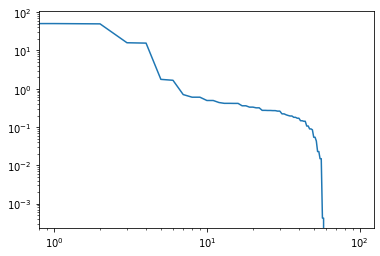

In [35]:
calc_NTK_2d(numerical_kernel_entry, k=1) # regular 1st-order ReLU

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([[10.34235592, 10.00149422, 10.70086125, ...,  9.95661517,
        10.66458282,  9.14698848],
       [ 9.93987377, 10.4997145 , 10.01109101, ...,  9.43915707,
        10.00238898, 10.186633  ],
       [ 9.97315833, 10.50158278,  9.29137031, ...,  9.50090939,
         8.48347675,  8.98198861],
       ...,
       [10.49439508,  9.82701388, 10.24348543, ...,  9.87171741,
         9.32716342,  9.34639707],
       [10.36249516,  9.79057895,  9.36155829, ..., 11.0934451 ,
        10.44996189,  9.22768955],
       [11.73008035, 10.31434243,  9.26608713, ...,  9.341584  ,
        10.37217931,  9.51789492]])

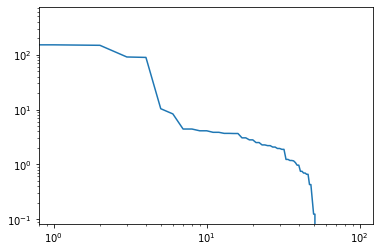

In [10]:
calc_NTK_2d(numerical_kernel_entry, k=2)

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([[52.13057099, 50.77355252, 46.91336834, ..., 38.94142403,
        37.54243169, 36.8471357 ],
       [42.94916192, 47.48659772, 38.14218029, ..., 45.17718206,
        50.63232645, 41.95867705],
       [27.35741226, 42.28185182, 35.35400622, ..., 30.38711841,
        30.75897458, 39.63658364],
       ...,
       [48.56056475, 38.86131229, 41.05067122, ..., 38.76400466,
        49.75250745, 38.68712452],
       [42.2914967 , 30.25644374, 57.90549492, ..., 44.24123968,
        40.38634579, 48.70107485],
       [42.98839545, 40.15136698, 35.55343834, ..., 38.99569398,
        44.5247691 , 47.6465104 ]])

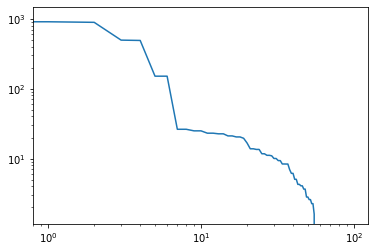

In [11]:
calc_NTK_2d(numerical_kernel_entry, k=3)

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([[512.04840717, 579.95499653, 684.80905892, ..., 608.05474461,
        421.5426543 , 431.49211567],
       [406.83909953, 365.64905937, 482.19447369, ..., 404.16338006,
        435.20522389, 428.45835078],
       [321.75543184, 364.67602017, 434.90310023, ..., 287.27803271,
        493.69719862, 415.04485797],
       ...,
       [398.11475669, 312.78057232, 414.98790839, ..., 753.76727174,
        475.82578788, 369.71273785],
       [441.94931788, 394.09098737, 356.32799451, ..., 372.5642653 ,
        445.85633238, 473.80066978],
       [687.42468796, 521.20512457, 432.19287183, ..., 227.43670775,
        595.70185641, 373.75416862]])

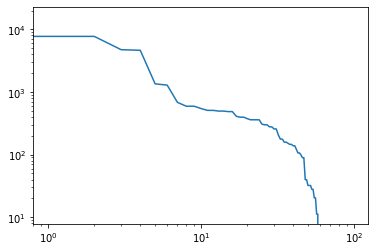

In [12]:
calc_NTK_2d(numerical_kernel_entry, k=4)

In [31]:
def calc_NTK_2d_trig(kernel_entry_func, k=1, activation='relu_k'):
    num_inputs = 100
    pi = np.pi
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniform
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta)))

    # make kernel
    kernel = np.zeros((num_inputs, num_inputs))

    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = kernel_entry_func(x[:, i], x[:, j], k, activation)
    
    # sort eigenvalues in descending order
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1] 
    # plt.plot(sorted_eigenvalues)
    plt.yscale('log')
    plt.plot(sorted_eigenvalues[:-1])
    return eigenvalues
#     return kernel

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([ 9.41033160e+01+0.j        ,  9.21834462e+01+0.j        ,
        6.81887776e+00+0.j        ,  6.67413462e+00+0.j        ,
        2.77158615e-02+0.2846842j ,  2.77158615e-02-0.2846842j ,
        6.77128206e-02+0.26342948j,  6.77128206e-02-0.26342948j,
        1.75941355e-01+0.20775391j,  1.75941355e-01-0.20775391j,
        2.13089403e-01+0.16915107j,  2.13089403e-01-0.16915107j,
        2.69724799e-01+0.04927947j,  2.69724799e-01-0.04927947j,
       -2.57305406e-01+0.0895221j , -2.57305406e-01-0.0895221j ,
       -9.38708756e-03+0.25704588j, -9.38708756e-03-0.25704588j,
       -1.93374025e-01+0.17480392j, -1.93374025e-01-0.17480392j,
       -7.55047198e-02+0.24532339j, -7.55047198e-02-0.24532339j,
       -2.58271267e-01+0.03076022j, -2.58271267e-01-0.03076022j,
        1.17665683e-01+0.21794421j,  1.17665683e-01-0.21794421j,
       -1.46055496e-01+0.1904691j , -1.46055496e-01-0.1904691j ,
       -9.98610425e-02+0.21213429j, -9.98610425e-02-0.21213429j,
       -2.02559471e-01+0.

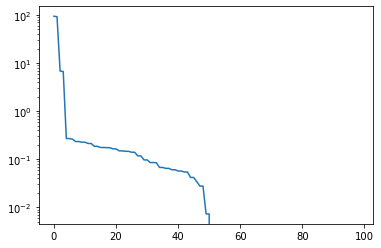

In [32]:
calc_NTK_2d_trig(numerical_kernel_entry, activation='sin')
# fix: y log scale keep x , instead of log-log

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


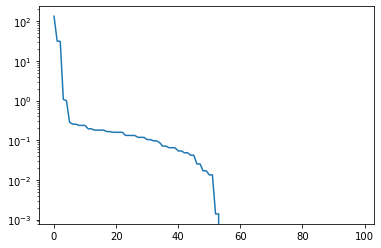

In [26]:
calc_NTK_2d_trig(numerical_kernel_entry, activation='cos')

In [30]:
eigenvalues[:50]

array([ 1.34787559e+02+0.j        ,  3.19243761e+01+0.j        ,
        3.12942868e+01+0.j        ,  1.07475773e+00+0.j        ,
        1.00082799e+00+0.j        , -2.51649225e-01+0.14845j   ,
       -2.51649225e-01-0.14845j   ,  2.54458174e-02+0.29053714j,
        2.54458174e-02-0.29053714j,  1.66359380e-01+0.23940979j,
        1.66359380e-01-0.23940979j,  2.87142460e-01+0.j        ,
       -2.07758251e-01+0.18290794j, -2.07758251e-01-0.18290794j,
       -2.72501664e-01+0.j        ,  1.34641223e-02+0.26647865j,
        1.34641223e-02-0.26647865j, -2.06276119e-01+0.15924448j,
       -2.06276119e-01-0.15924448j, -4.87164509e-02+0.25553532j,
       -4.87164509e-02-0.25553532j, -2.40877527e-01+0.07437495j,
       -2.40877527e-01-0.07437495j, -1.16686018e-01+0.22749512j,
       -1.16686018e-01-0.22749512j,  2.56323786e-01+0.08057859j,
        2.56323786e-01-0.08057859j,  9.72896825e-02+0.22314872j,
        9.72896825e-02-0.22314872j,  1.59736677e-01+0.18456047j,
        1.59736677e-01-0.

In [15]:
# calculate Laplace Kernel

def laplace_kernel_entry(x, y, sigma):
    """
    x are y in R^2
    """
    return np.exp(-np.linalg.norm(x - y) / sigma)

In [16]:
# execute
def calc_laplace_2d(sigma):
    num_inputs = 100
    pi = np.pi
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniform
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta)))

    # make kernel
    kernel = np.zeros((num_inputs, num_inputs))

    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = laplace_kernel_entry(x[:, i], x[:, j], sigma)
    
    # sort eigenvalues in descending order
    global eigenvalues 
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1] 
    # plt.plot(sorted_eigenvalues)
    plt.loglog(sorted_eigenvalues[:-1])

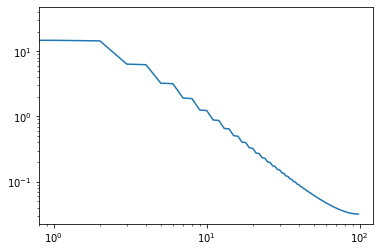

In [17]:
calc_laplace_2d(sigma=1.0)

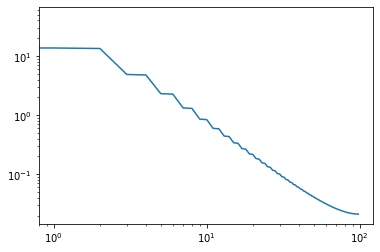

In [18]:
calc_laplace_2d(sigma=1.5)

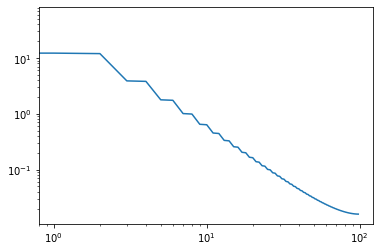

In [19]:
calc_laplace_2d(sigma=2.0)

array([[2.        , 1.97583912, 1.94404729, ..., 1.94404729, 1.97583912,
        2.        ],
       [1.97583912, 2.        , 1.97583912, ..., 1.90507628, 1.94404729,
        1.97583912],
       [1.94404729, 1.97583912, 2.        , ..., 1.85940414, 1.90507628,
        1.94404729],
       ...,
       [1.94404729, 1.90507628, 1.85940414, ..., 2.        , 1.97583912,
        1.94404729],
       [1.97583912, 1.94404729, 1.90507628, ..., 1.97583912, 2.        ,
        1.97583912],
       [2.        , 1.97583912, 1.94404729, ..., 1.94404729, 1.97583912,
        2.        ]])

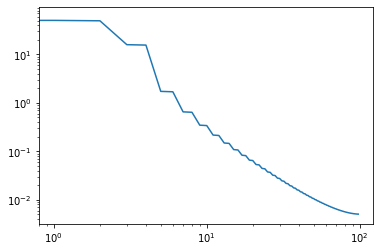

In [20]:
calc_NTK_2d(analytic_kernel_entry_2d)